# Business Cycle - Equities

## Imports

In [268]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [269]:
frequency = 1
t_cost = 0
target_vol = 0.10
min_regions = 4
lag_months = 3

## Data

### Riskfree Data

In [270]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
riskfree

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_91480/2677495952.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Factor Data

In [271]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_91480/297690613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0221,0.0256
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184


### Benchmark Data

In [272]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


### Macro Data

In [273]:
# --- Load Macro Data ---
rgdp_data = pd.read_excel(
    f"{path}/Macro Data.xlsx",
    sheet_name = 'RGDP',
    index_col='Date', # Use the column name 'Date' for the index
    parse_dates=True
)

cpi_data = pd.read_excel(
    f"{path}/Macro Data.xlsx",
    sheet_name = 'CPI',
    index_col='Date', # Use the column name 'Date' for the index
    parse_dates=True
)

# --- Align and Forward-Fill RGDP Data ---

# Get the monthly index from the CPI data
monthly_index = cpi_data.index

# Reindex the quarterly RGDP data to the monthly frequency.
# This introduces NaN values for the months that are not the start of a quarter.
rgdp_monthly = rgdp_data.reindex(monthly_index)

# Forward-fill (ffill) the NaN values.
# This carries the quarterly value forward to the subsequent two months.
rgdp_ffilled = rgdp_monthly.ffill()

rgdp_ffilled.index = rgdp_ffilled.index + pd.offsets.MonthEnd(0)

# Adjust the CPI DataFrame index to month-end
cpi_data.index = cpi_data.index + pd.offsets.MonthEnd(0)

# --- Final DataFrames ---
rgdp_final = rgdp_ffilled
cpi_final = cpi_data

display(rgdp_final)
display(cpi_final)

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1970-01-31,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-02-28,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-03-31,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-04-30,-0.247900,8.3,NaN,NaN,10.8,NaN,NaN
1970-05-31,-0.247900,8.3,NaN,NaN,10.8,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,3.500000,2.1,1.3,0.5,1.1,1.4,4.8
2025-08-31,3.500000,2.1,1.3,0.5,1.1,1.4,4.8
2025-09-30,3.500000,2.1,1.3,0.5,1.1,1.4,4.8


,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1970-01-31,6.162465,NaN,4.9,2.3,NaN,NaN,NaN
1970-02-28,6.424581,NaN,4.9,2.1,NaN,NaN,NaN
1970-03-31,6.094183,2.1,5.0,2.5,NaN,NaN,NaN
1970-04-30,6.060606,2.1,5.4,2.6,NaN,NaN,NaN
1970-05-31,6.043956,2.1,5.7,3.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,2.731801,2.1,3.8,0.2,3.1,2.0,0.0
2025-08-31,2.939220,2.1,3.8,0.2,2.7,2.0,-0.4
2025-09-30,3.022700,3.2,3.8,0.2,2.9,2.2,-0.3


### Equity Data

In [274]:
# --- Load Equity Price Data ---
equity_prices = pd.read_excel(
    f"{path}/Equity Data.xlsx",
    index_col = 0,
    parse_dates = True
)
equity_prices.index = pd.to_datetime(equity_prices.index)
equity_prices.index = equity_prices.index + pd.offsets.MonthEnd(0)

display(equity_prices)

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,1206.821289,NaN,NaN,7.33429,7487.55371,NaN,NaN
1997-10-31,1168.258667,NaN,NaN,6.82642,7084.46436,NaN,NaN
1997-11-30,1207.453491,NaN,NaN,6.34016,7152.55615,NaN,NaN
1997-12-31,1223.840210,NaN,NaN,5.86087,7365.37451,NaN,NaN
1998-01-31,1234.778442,NaN,NaN,6.36481,7690.75049,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,6308.888672,5641.31592,14994.83984,19.64406,12121.12598,14955.800000,6276.48438
2025-07-31,6430.451172,5627.64307,14552.98438,19.41757,12131.93066,15094.600000,6109.94238
2025-08-31,6529.819336,5881.38037,15274.74121,20.75129,12521.77637,15223.700000,6284.96094


In [275]:
# --- Equity Returns ---
equity_XR = equity_prices.pct_change()
equity_XR = equity_XR.resample('ME').last()

display(equity_XR.loc['2005-01-31':'2007-12-31'])

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
2005-01-31,-0.026365,-0.002756,-0.034969,-0.010223,-0.011439,NaN,-0.028410
2005-02-28,0.018828,0.039942,0.048548,0.022988,0.047124,NaN,0.033928
2005-03-31,-0.019906,-0.034317,-0.020210,-0.017579,-0.028978,NaN,-0.021526
2005-04-30,-0.021537,-0.022679,-0.003636,-0.037304,-0.012445,NaN,-0.036414
2005-05-31,0.029132,-0.001164,0.005140,-0.003285,-0.012490,NaN,0.015978
2005-06-30,-0.001604,0.043773,-0.011961,0.003322,0.011242,NaN,0.014484
2005-07-31,0.034504,0.016873,0.052370,0.013453,0.010083,NaN,0.043576
2005-08-31,-0.012331,0.010079,0.014654,0.069596,0.030240,NaN,-0.000819
2005-09-30,0.005318,0.057390,0.026563,0.085347,0.008280,NaN,0.022186


## Signal Generation

In [276]:
# --- Compute Business Cycle Signal ---
rgdp_component = rgdp_final.diff(12).loc['1980-01-31':]

display("YoY change in RGDP:")
display(rgdp_component.tail(10))

# # Reindex RGDP trend to match CPI trend index exactly
# RGDP_component = RGDP_trend.reindex(CPI_trend.index).ffill()
# CPI_component = CPI_trend

'YoY change in RGDP:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
2025-02-28,-0.919374,0.3,1.4,2.3,2.9,1.1,0.1
2025-03-31,-0.919374,0.3,1.4,2.3,2.9,1.1,0.1
2025-04-30,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-05-31,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-06-30,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-07-31,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-08-31,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-09-30,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-10-31,1.016180,0.8,-0.6,-1.0,0.1,0.1,-0.6


In [277]:
cpi_component = cpi_final.diff(12).loc['1980-01-31':]

display("YoY change in CPI:")
display(cpi_component.tail(10))

'YoY change in CPI:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
2025-02-28,-0.351473,-1.7,-0.6,-0.9,0.9,-0.3,-1.4
2025-03-31,-1.069546,-1.2,-0.6,-0.7,0.9,-0.2,-0.2
2025-04-30,-1.023985,-1.2,1.2,-1.4,1.1,-0.2,-0.4
2025-05-31,-0.874276,-1.2,1.4,-1.5,0.7,-0.7,-0.4
2025-06-30,-0.302945,-1.7,1.6,-1.2,0.5,-0.5,-0.1
2025-07-31,-0.191765,-1.7,1.6,-1.1,0.3,-0.6,-0.5
2025-08-31,0.347993,-1.7,1.6,-0.9,-0.3,-0.2,-1.0
2025-09-30,0.615186,0.4,2.1,-0.6,0.4,0.5,-0.7
2025-10-31,0.446374,0.4,1.3,-0.5,0.7,0.1,-0.1


In [278]:
# --- Composite Signal Construction ---
# Logic: For Equities, we want High Growth (+) and Low Inflation (-)
# We combine them: 50% Growth, 50% Inverse Inflation
business_cyle_signal = (0.5 * rgdp_component) - (0.5 * cpi_component)
business_cyle_signal = business_cyle_signal.resample('ME').last()

display("Business Cycle Signal:")
display(business_cyle_signal.loc['2005-01-31':'2007-12-31'])

'Business Cycle Signal:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
2005-01-31,-1.124750,-0.85,-0.182771,-1.00,-1.100000e+00,-0.20,0.90
2005-02-28,-1.288743,-0.85,-0.282771,-1.15,-8.500000e-01,-0.40,-0.65
2005-03-31,-1.365730,-1.00,-0.482771,-1.25,-9.500000e-01,-0.40,0.40
2005-04-30,-1.158996,-1.35,-1.379708,-0.80,-4.500000e-01,-0.45,0.75
2005-05-31,-0.475877,-1.35,-1.179708,-0.45,-6.000000e-01,-0.20,1.05
2005-06-30,-0.232747,-1.15,-1.179708,-0.15,-1.110223e-16,-0.25,1.45
2005-07-31,-0.245620,-0.35,-1.149726,0.25,-1.500000e-01,0.10,1.55
2005-08-31,-0.650792,-0.35,-1.249726,0.40,-2.000000e-01,0.10,1.80
2005-09-30,-1.287089,-0.75,-1.399726,0.15,-1.000000e-01,-0.25,1.95


## Portfolio Construction

In [279]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal= business_cyle_signal,
    returns= equity_XR,
    min_regions=min_regions,
    signal_lag= lag_months,
    vol_target=target_vol,
    vol_lookback=24
)

In [280]:
weights_raw.tail(15)

,US,AU,UK,CH,JP,EU,EM
2024-07-31,0.000000,-0.462910,1.388730,0.462910,-0.925820,0.925820,-1.388730
2024-08-31,-0.462910,0.000000,1.388730,0.462910,-1.388730,0.925820,-0.925820
2024-09-30,-0.462910,0.000000,1.388730,0.462910,-0.925820,0.925820,-1.388730
2024-10-31,-0.462910,0.000000,1.388730,0.462910,-0.925820,0.925820,-1.388730
2024-11-30,-0.462910,0.000000,1.388730,0.462910,-0.925820,0.925820,-1.388730
2024-12-31,-0.462910,0.000000,1.388730,0.462910,-0.925820,0.925820,-1.388730
2025-01-31,-0.934199,0.934199,1.401298,0.233550,-0.467099,0.233550,-1.401298
2025-02-28,-0.925820,0.925820,1.388730,0.462910,-0.462910,0.000000,-1.388730
2025-03-31,-0.462910,0.000000,1.388730,0.925820,-1.388730,0.462910,-0.925820
2025-04-30,-0.925820,0.462910,0.925820,1.388730,-0.462910,0.000000,-1.388730


In [281]:
weights = pmp.append_final_zero_row(weights)
display(weights.loc['2005-01-31':'2007-12-31'])

,US,AU,UK,CH,JP,EU,EM
2005-01-31,-0.606517,-0.121303,0.606517,0.121303,-0.363910,0.363910,NaN
2005-02-28,-0.635038,-0.033423,0.367654,0.167115,-0.434500,0.568192,NaN
2005-03-31,-0.601203,-0.200401,0.400802,0.200401,-0.400802,0.601203,NaN
2005-04-30,-0.846802,0.169360,0.846802,-0.169360,-0.508081,0.508081,NaN
2005-05-31,-0.753016,0.044295,0.841606,-0.487245,-0.221475,0.575836,NaN
2005-06-30,-0.891902,-0.178380,0.535141,-0.535141,0.178380,0.891902,NaN
2005-07-31,-0.176944,-0.530832,-0.884720,0.176944,0.530832,0.884720,NaN
2005-08-31,0.189213,-0.946066,-0.567640,0.567640,-0.189213,0.946066,NaN
2005-09-30,0.182109,-0.546327,-0.910544,0.546327,0.910544,-0.182109,NaN
2005-10-31,-0.160466,-0.481397,-0.802329,0.802329,0.160466,0.481397,NaN


In [282]:
# debugging
portfolio_returns = weights * equity_XR
# portfolio_returns = portfolio_returns.sum(axis = 1)
display(portfolio_returns.loc['2005-01-31':'2007-12-31'])

,AU,CH,EM,EU,JP,UK,US
2005-01-31,0.000334,-0.004242,NaN,-0.010339,0.003720,-0.006938,0.015991
2005-02-28,-0.001335,0.008113,NaN,0.019278,-0.009988,0.017325,-0.011956
2005-03-31,0.006877,-0.004050,NaN,-0.012942,0.007046,-0.011615,0.011967
2005-04-30,-0.003841,0.000616,NaN,-0.018501,0.018953,-0.010538,0.018238
2005-05-31,-0.000052,-0.002504,NaN,0.009201,0.000727,-0.010512,-0.021937
2005-06-30,-0.007808,0.006401,NaN,0.012918,0.000593,0.006016,0.001431
2005-07-31,-0.008957,0.009267,NaN,0.038553,0.007141,-0.008920,-0.006105
2005-08-31,-0.009536,0.008318,NaN,-0.000775,-0.013169,-0.017166,-0.002333
2005-09-30,-0.031354,0.014512,NaN,-0.004040,0.077712,-0.007540,0.000968
2005-10-31,0.028643,0.017752,NaN,-0.018651,0.000642,0.022199,0.003185


## Backtest

In [283]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = equity_XR,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

results

results.to_csv('macroBC_equity.csv')

## Performance Statistics

In [284]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,6.3522,4.7176
Arithm Avg Xs Return,4.6031,2.9684
Std Xs Returns,9.7927,16.9745
Sharpe Arithmetic,0.4700,0.1749
Geom Avg Total Return,6.0338,3.6148
Geom Avg Xs Return,4.2721,1.8531
Sharpe Geometric,0.4363,0.1092
Min Xs Return,-10.2114,-11.7112
Max Xs Return,8.6715,68.5148
Skewness,-0.4506,8.9682


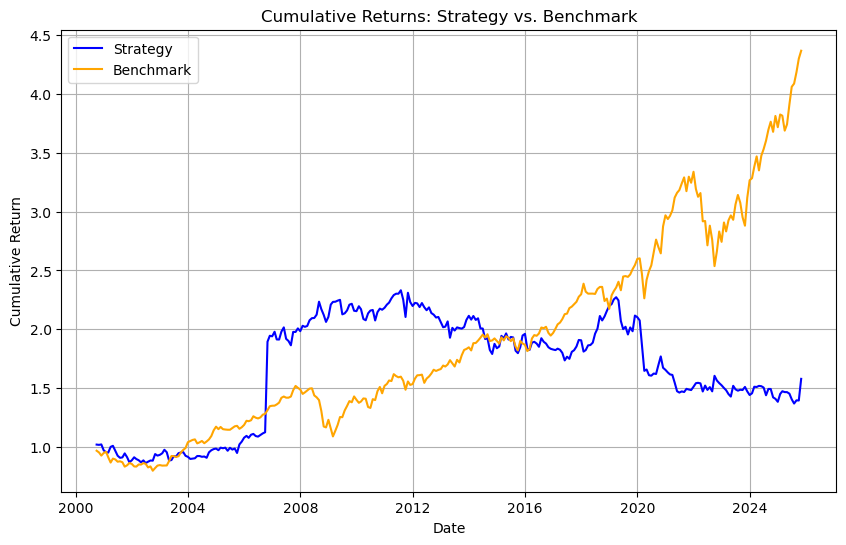

In [289]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

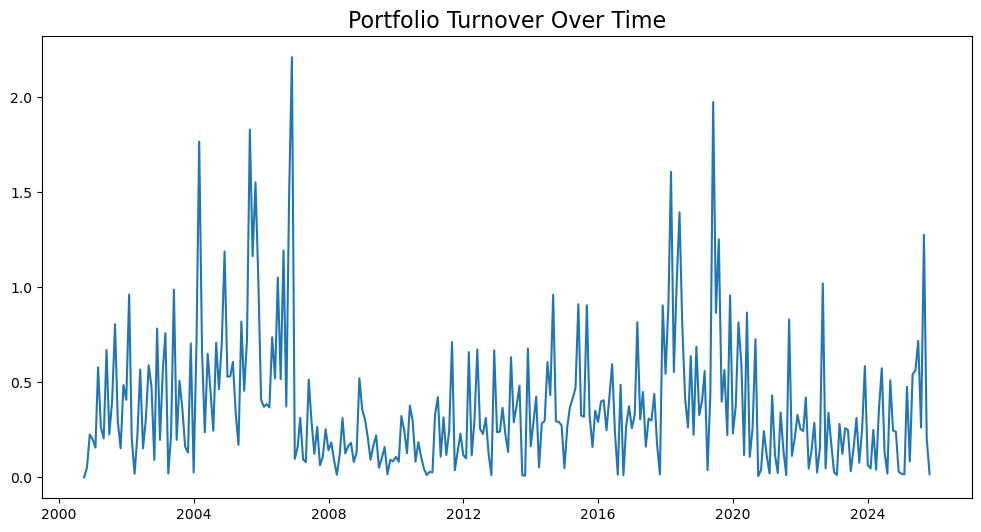

In [286]:
plt.figure(figsize=(12,6))
plt.plot(results["turnover"])
plt.title("Portfolio Turnover Over Time", fontsize=16)
plt.show()

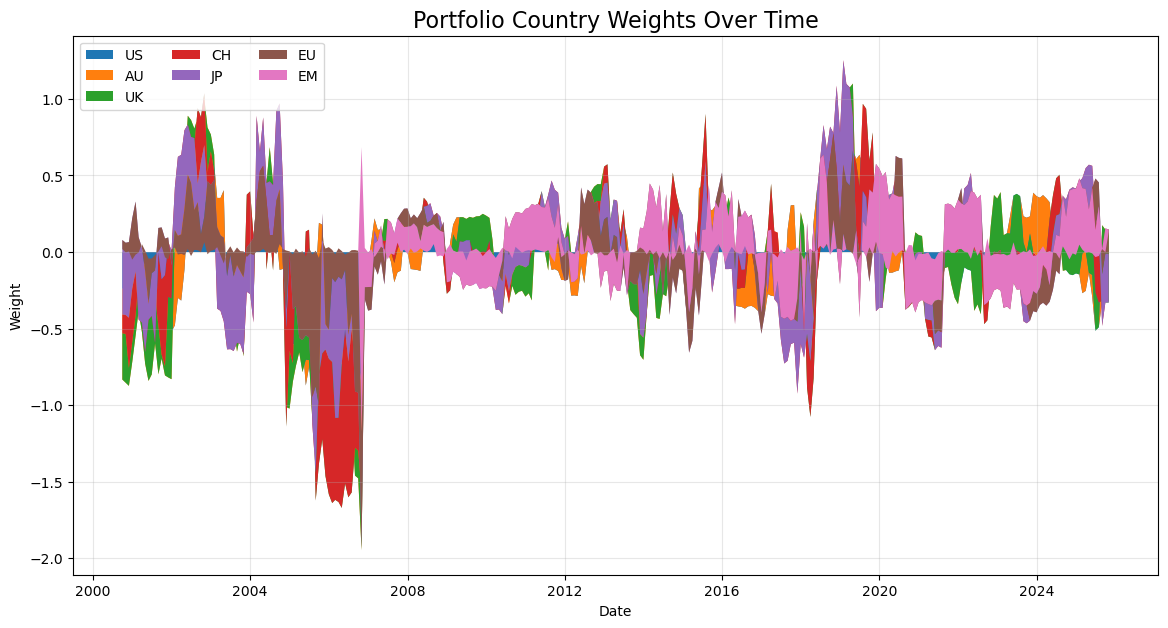

In [287]:
weight_cols = [col for col in results.columns if col.startswith("w_")]
weights = results[weight_cols].copy()

weights.columns = [col.replace("w_", "") for col in weight_cols]

plt.figure(figsize=(14, 7))
plt.stackplot(weights.index, weights.T, labels=weights.columns)

plt.title("Portfolio Country Weights Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend(loc="upper left", ncols=3)
plt.grid(alpha=0.3)
plt.show()